# Comprehensive Residue Feature Extraction with abagpdb

This notebook demonstrates how to use the **`residue_features.py`** module to extract comprehensive features from protein complexes. This module combines all available analyses from the package into a unified residue-level feature representation.

## What Features Are Extracted?

The `extract_residue_features()` function computes:

1. **Basic Properties**: Chain ID, residue name, sequence number
2. **Structural Geometry**: Backbone angles (phi, psi, omega), sidechain rotamers (chi1-4), bend angles
3. **Surface Accessibility**: SASA (solvent accessible surface area), burial fraction
4. **Distance Metrics**: Distances to partner chains, sequence neighbors
5. **Interface Participation**: Interface residues, contact counts, partner residues
6. **Molecular Interactions**: H-bonds, salt bridges, hydrophobic contacts, pi-stacking, disulfides
7. **Van der Waals Energy**: LJ decomposition energies
8. **Chemical Properties**: Charge, polarity, hydrophobicity, aromaticity
9. **B-factors**: Average, min, max B-factors

## Use Cases

- **Machine Learning**: Create feature matrices for ML models
- **Hotspot Identification**: Find critical residues for binding
- **Comparative Analysis**: Compare features across structures
- **Mutation Effect Prediction**: Analyze residue importance

---

## 1. Setup and Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Import abagpdb modules
from abagpdb.pdbparser import parse_pdb
from abagpdb.residue_features import (
    extract_residue_features,
    features_to_dataframe,
    export_features_csv,
    export_features_json,
    filter_interface_residues,
    identify_hotspots,
    get_feature_summary
)
from abagpdb.visualization.residue_feat_viz import create_interactive_dashboard

## 2. Load PDB Structure

We'll use the 5GGS antibody-antigen complex:
- **Chains H, L**: Antibody (heavy and light chains)
- **Chain A**: Antigen protein

In [3]:
# Parse PDB file
cx = parse_pdb("5GGS_wt.pdb")

print("=" * 60)
print("PDB STRUCTURE LOADED".center(60))
print("=" * 60)
print(f"File:         5GGS_wt.pdb")
print(f"Chains:       {', '.join(cx.chains.keys())}")
print(f"Total atoms:  {sum(len(list(c.iter_atoms())) for c in cx.chains.values())}")
print("=" * 60)

                    PDB STRUCTURE LOADED                    
File:         5GGS_wt.pdb
Chains:       A, H, L
Total atoms:  4216


## 3. Extract Comprehensive Residue Features

The main function `extract_residue_features()` orchestrates all analyses:

### Parameters:
- `cx`: Complex structure
- `selection_A`: First selection (e.g., antibody chains ["H", "L"])
- `selection_B`: Second selection (e.g., antigen chain ["A"])
- `interface_cutoff`: Distance cutoff for interface (default: 5.0 Å)
- `compute_sasa`: Calculate SASA (default: True)
- `compute_geometry`: Calculate angles (default: True)
- `compute_vdw`: Calculate VdW energies (default: True)

In [4]:
# Extract features for antibody-antigen interface
# Selection A: Antibody (chains H and L)
# Selection B: Antigen (chain A)

features = extract_residue_features(
    cx=cx,
    selection_A=["H", "L"],  # Antibody
    selection_B=["A"],        # Antigen
    interface_cutoff=5.0,
    compute_sasa=True,
    compute_geometry=True,
    compute_vdw=True,
    verbose=True
)

Starting comprehensive residue feature extraction...
  Total residues in complex: 549
  [1/7] Initializing basic features...
  [2/7] Computing backbone and sidechain angles...
  [3/7] Computing solvent accessible surface area...
  [4/7] Computing distance features...
  [5/7] Analyzing interface residues...
  [6/7] Detecting molecular interactions...
  [7/7] Computing Van der Waals contacts...
  Extraction complete! Features generated for 549 residues.
  - Interface residues: 59
  - Potential hotspots: 11


## 4. Inspect Feature Data

The result is a dictionary mapping `residue_id → ResidueFeatures` object.

Residue ID format: `"RESNAME CHAIN:RESSEQ"` (e.g., `"TYR H:32"`)

In [5]:
print(f"\nTotal residues with features: {len(features)}")
print(f"\nFirst 5 residue IDs:")
for i, res_id in enumerate(list(features.keys())[:5]):
    print(f"  {i+1}. {res_id}")


Total residues with features: 549

First 5 residue IDs:
  1. PRO A:1
  2. TRP A:2
  3. ASN A:3
  4. PRO A:4
  5. PRO A:5


In [6]:
# Examine a single residue feature in detail
sample_res_id = list(features.keys())[0]
sample_feat = features[sample_res_id]

print("=" * 80)
print(f"EXAMPLE RESIDUE: {sample_res_id}".center(80))
print("=" * 80)

print(f"\n📍 Basic Information:")
print(f"   Chain:              {sample_feat.chain_id}")
print(f"   Residue name:       {sample_feat.resname}")
print(f"   Sequence number:    {sample_feat.resseq}")
print(f"   Heavy atoms:        {sample_feat.num_heavy_atoms}")

print(f"\n🧪 Chemical Properties:")
print(f"   Charged:            {sample_feat.is_charged}")
print(f"   Polar:              {sample_feat.is_polar}")
print(f"   Hydrophobic:        {sample_feat.is_hydrophobic}")
print(f"   Aromatic:           {sample_feat.is_aromatic}")

print(f"\n📐 Geometry:")
print(f"   Phi angle:          {sample_feat.phi:.2f}°" if sample_feat.phi else "   Phi angle:          N/A")
print(f"   Psi angle:          {sample_feat.psi:.2f}°" if sample_feat.psi else "   Psi angle:          N/A")
print(f"   Secondary structure: {sample_feat.secondary_structure if sample_feat.secondary_structure else 'N/A'}")

print(f"\n🔗 Interface:")
print(f"   Is interface:       {sample_feat.is_interface}")
print(f"   Contact count:      {sample_feat.interface_contact_count}")
print(f"   Partner residues:   {sample_feat.num_partner_residues}")

print(f"\n⚡ Interactions:")
print(f"   H-bonds:            {sample_feat.num_hbonds}")
print(f"   Salt bridges:       {sample_feat.num_salt_bridges}")
print(f"   Hydrophobic:        {sample_feat.num_hydrophobic}")
print(f"   Pi-stacking:        {sample_feat.num_pi_stacking}")
print(f"   Total interactions: {sample_feat.total_interactions}")

print(f"\n💧 SASA:")
if sample_feat.bound_sasa is not None:
    print(f"   Bound SASA:         {sample_feat.bound_sasa:.2f} Ų")
    print(f"   Unbound SASA:       {sample_feat.unbound_sasa:.2f} Ų")
    print(f"   Buried fraction:    {sample_feat.buried_fraction:.2%}" if sample_feat.buried_fraction else "   Buried fraction:    N/A")
else:
    print(f"   SASA data not available")

print(f"\n🎯 Hotspot Candidate: {sample_feat.is_hotspot_candidate}")
print("=" * 80)

                            EXAMPLE RESIDUE: PRO A:1                            

📍 Basic Information:
   Chain:              A
   Residue name:       PRO
   Sequence number:    1
   Heavy atoms:        7

🧪 Chemical Properties:
   Charged:            False
   Polar:              False
   Hydrophobic:        True
   Aromatic:           False

📐 Geometry:
   Phi angle:          N/A
   Psi angle:          139.10°
   Secondary structure: N/A

🔗 Interface:
   Is interface:       False
   Contact count:      0
   Partner residues:   0

⚡ Interactions:
   H-bonds:            0
   Salt bridges:       0
   Hydrophobic:        0
   Pi-stacking:        0
   Total interactions: 0

💧 SASA:
   Bound SASA:         164.58 Ų
   Unbound SASA:       164.58 Ų
   Buried fraction:    N/A

🎯 Hotspot Candidate: False


## 5. Convert to Pandas DataFrame

For easy analysis and filtering, convert features to a DataFrame.

In [7]:
# Convert to DataFrame
df = features_to_dataframe(features)

print(f"DataFrame shape: {df.shape}")
print(f"Columns: {len(df.columns)}")
print(f"\nColumn names:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")

DataFrame shape: (549, 49)
Columns: 49

Column names:
   1. chain_id
   2. resname
   3. resseq
   4. icode
   5. residue_id
   6. phi
   7. psi
   8. omega
   9. bend_angle
  10. chi1
  11. chi2
  12. chi3
  13. chi4
  14. unbound_sasa
  15. bound_sasa
  16. delta_sasa
  17. buried_fraction
  18. min_dist_to_partner
  19. ca_dist_to_partner
  20. avg_dist_to_neighbors
  21. is_interface
  22. interface_contact_count
  23. num_partner_residues
  24. partner_residue_ids
  25. num_hbonds
  26. num_salt_bridges
  27. num_hydrophobic
  28. num_pi_stacking
  29. num_disulfides
  30. total_interactions
  31. interaction_types
  32. hbond_partners
  33. salt_bridge_partners
  34. hydrophobic_partners
  35. pi_stacking_partners
  36. vdw_energy
  37. is_charged
  38. is_polar
  39. is_hydrophobic
  40. is_aromatic
  41. is_positive
  42. is_negative
  43. secondary_structure
  44. num_heavy_atoms
  45. num_all_atoms
  46. avg_bfactor
  47. max_bfactor
  48. min_bfactor
  49. custom_features


In [8]:
# Display first few rows
df.head(10)

,chain_id,resname,resseq,icode,residue_id,phi,psi,omega,bend_angle,chi1,...,is_aromatic,is_positive,is_negative,secondary_structure,num_heavy_atoms,num_all_atoms,avg_bfactor,max_bfactor,min_bfactor,custom_features
0,A,PRO,1,,PRO A:1,NaN,139.101488,-20.527456,NaN,9.824920,...,False,False,False,None,7,7,60.644286,69.05,55.10,{}
1,A,TRP,2,,TRP A:2,-162.973685,153.003690,-176.398211,164.629689,49.750632,...,True,False,False,beta_sheet,14,14,43.902143,54.28,34.02,{}
2,A,ASN,3,,ASN A:3,-108.413039,160.816890,177.080954,134.209355,-78.648045,...,False,False,False,beta_sheet,8,8,48.366250,59.02,40.06,{}
3,A,PRO,4,,PRO A:4,-67.273719,150.303875,178.386680,117.170985,22.345391,...,False,False,False,loop,7,7,38.778571,41.38,34.91,{}
4,A,PRO,5,,PRO A:5,-68.750708,161.579576,172.738292,121.687742,25.663365,...,False,False,False,loop,7,7,37.760000,39.34,34.83,{}
5,A,THR,6,,THR A:6,-101.248803,154.931173,-171.723006,122.207678,60.246455,...,False,False,False,beta_sheet,7,7,38.740000,44.02,35.43,{}
6,A,PHE,7,,PHE A:7,-142.429843,114.098472,-173.301015,125.508812,-165.083856,...,True,False,False,beta_sheet,11,11,35.582727,48.37,31.49,{}
7,A,SER,8,,SER A:8,-136.827370,158.852609,-2.860088,152.105146,56.206588,...,False,False,False,beta_sheet,6,6,48.155000,54.65,42.80,{}
8,A,PRO,9,,PRO A:9,-77.021395,160.158641,177.883450,99.878067,30.685550,...,False,False,False,loop,7,7,47.720000,51.66,43.84,{}
9,A,ALA,10,,ALA A:10,-60.786996,-35.379521,178.101150,87.708611,NaN,...,False,False,False,alpha_helix,5,5,51.158000,57.49,44.20,{}


## 6. Feature Summary Statistics

Get overview statistics across all residues.

In [9]:
# Get summary statistics
summary = get_feature_summary(features)

print("=" * 60)
print("FEATURE SUMMARY STATISTICS".center(60))
print("=" * 60)

print(f"\n📊 Residue Counts:")
print(f"   Total residues:         {summary['total_residues']}")
print(f"   Interface residues:     {summary['interface_residues']}")
print(f"   Hotspot candidates:     {summary['hotspot_candidates']}")

print(f"\n🧪 Chemical Composition:")
print(f"   Charged residues:       {summary['charged_residues']}")
print(f"   Hydrophobic residues:   {summary['hydrophobic_residues']}")
print(f"   Aromatic residues:      {summary['aromatic_residues']}")

print(f"\n⚡ Interactions:")
print(f"   Total H-bonds:          {summary['total_hbonds']}")
print(f"   Total salt bridges:     {summary['total_salt_bridges']}")
print(f"   Total hydrophobic:      {summary['total_hydrophobic']}")
print(f"   Total pi-stacking:      {summary['total_pi_stacking']}")
print(f"   Avg interactions/res:   {summary['avg_interactions_per_residue']:.2f}")
print(f"   Max interactions:       {summary['max_interactions']}")

if 'avg_delta_sasa' in summary:
    print(f"\n💧 SASA:")
    print(f"   Avg ΔSASA:              {summary['avg_delta_sasa']:.2f} Ų")
    print(f"   Buried residues (>50%): {summary['buried_residues']}")

print("=" * 60)

                 FEATURE SUMMARY STATISTICS                 

📊 Residue Counts:
   Total residues:         549
   Interface residues:     59
   Hotspot candidates:     11

🧪 Chemical Composition:
   Charged residues:       105
   Hydrophobic residues:   202
   Aromatic residues:      64

⚡ Interactions:
   Total H-bonds:          38
   Total salt bridges:     14
   Total hydrophobic:      130
   Total pi-stacking:      0
   Avg interactions/res:   0.33
   Max interactions:       19

💧 SASA:
   Avg ΔSASA:              10.80 Ų
   Buried residues (>50%): 92


## 7. Analyze Interface Residues

Filter to only interface residues and examine their properties.

In [10]:
# Filter interface residues
interface_features = filter_interface_residues(features, min_contacts=1)

print(f"Interface residues: {len(interface_features)}")
print(f"Percentage: {len(interface_features)/len(features)*100:.1f}%")

# Convert to DataFrame
df_interface = features_to_dataframe(interface_features)

print(f"\nInterface residues by chain:")
print(df_interface['chain_id'].value_counts())

Interface residues: 59
Percentage: 10.7%

Interface residues by chain:
chain_id
A    27
H    18
L    14
Name: count, dtype: int64


In [11]:
# Display top interface residues by interaction count
df_interface_sorted = df_interface.sort_values('total_interactions', ascending=False)

print("=" * 100)
print("TOP 20 INTERFACE RESIDUES BY INTERACTION COUNT".center(100))
print("=" * 100)

cols = ['residue_id', 'chain_id', 'resname', 'total_interactions', 
        'num_hbonds', 'num_salt_bridges', 'num_hydrophobic']
print(df_interface_sorted[cols].head(20).to_string(index=False))
print("=" * 100)

                           TOP 20 INTERFACE RESIDUES BY INTERACTION COUNT                           
residue_id chain_id resname  total_interactions  num_hbonds  num_salt_bridges  num_hydrophobic
 PHE H:102        H     PHE                  19           0                 0               19
  TYR L:34        L     TYR                  16           2                 0               14
  PRO A:53        A     PRO                  14           0                 0               14
  LEU A:98        A     LEU                  14           1                 0               13
  VAL A:34        A     VAL                  14           0                 0               14
  PRO A:59        A     PRO                  14           0                 0               14
  TYR L:57        L     TYR                  10           0                 0               10
  ARG H:98        H     ARG                   8           4                 4                0
  TYR H:32        H     TYR                 

## 8. Identify Hotspot Residues

Hotspots are interface residues with high interaction counts, particularly specific interactions like H-bonds or salt bridges.

In [13]:
# Identify hotspots
hotspots = identify_hotspots(
    features, 
    min_interactions=3,
    require_hbond_or_salt=True
)

print(f"Hotspot residues identified: {len(hotspots)}")
print(f"Percentage of interface: {len(hotspots)/len(interface_features)*100:.1f}%")

# Display hotspots
df_hotspots = features_to_dataframe(hotspots)
df_hotspots_sorted = df_hotspots.sort_values('total_interactions', ascending=False)

print("\n" + "=" * 100)
print("HOTSPOT RESIDUES".center(100))
print("=" * 100)

cols = ['residue_id', 'chain_id', 'resname', 'total_interactions', 
        'num_hbonds', 'num_salt_bridges', 'num_hydrophobic', 'num_pi_stacking',
        'interface_contact_count']
print(df_hotspots_sorted[cols].to_string(index=False))
print("=" * 100)

Hotspot residues identified: 11
Percentage of interface: 18.6%

                                          HOTSPOT RESIDUES                                          
residue_id chain_id resname  total_interactions  num_hbonds  num_salt_bridges  num_hydrophobic  num_pi_stacking  interface_contact_count
  TYR L:34        L     TYR                  16           2                 0               14                0                       54
  LEU A:98        A     LEU                  14           1                 0               13                0                       45
  TYR H:32        H     TYR                   8           1                 0                7                0                       46
  ARG H:98        H     ARG                   8           4                 4                0                0                       23
  ASP A:55        A     ASP                   7           3                 4                0                0                       31
 TYR H:100   

## 9. Visualizations

Create various plots to understand the feature distributions.

### 9.1 Interaction Distribution

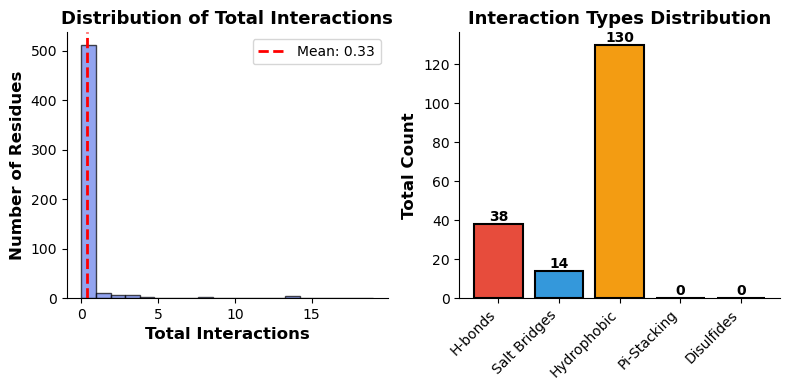

In [15]:
# Plot interaction distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Histogram of total interactions
interactions = df['total_interactions']
ax1.hist(interactions, bins=20, color='#667eea', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Total Interactions', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Residues', fontsize=12, fontweight='bold')
ax1.set_title('Distribution of Total Interactions', fontsize=13, fontweight='bold')
ax1.axvline(interactions.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {interactions.mean():.2f}')
ax1.legend()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Bar chart of interaction types
interaction_types = ['H-bonds', 'Salt Bridges', 'Hydrophobic', 'Pi-Stacking', 'Disulfides']
interaction_counts = [
    df['num_hbonds'].sum(),
    df['num_salt_bridges'].sum(),
    df['num_hydrophobic'].sum(),
    df['num_pi_stacking'].sum(),
    df['num_disulfides'].sum()
]
colors = ['#e74c3c', '#3498db', '#f39c12', '#9b59b6', '#1abc9c']

bars = ax2.bar(interaction_types, interaction_counts, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Total Count', fontsize=12, fontweight='bold')
ax2.set_title('Interaction Types Distribution', fontsize=13, fontweight='bold')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add value labels
for bar, count in zip(bars, interaction_counts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### 9.2 Interface vs Non-Interface Comparison

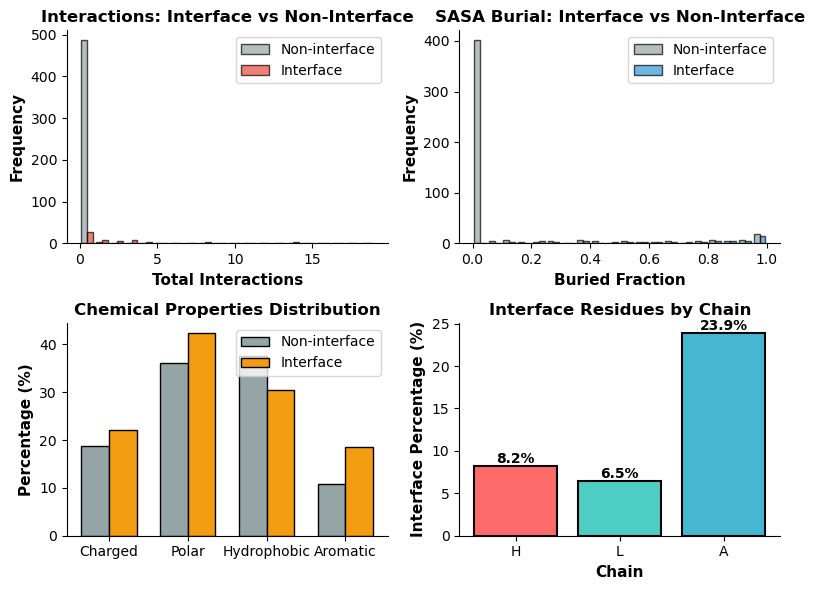

In [16]:
# Compare interface vs non-interface residues
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# 1. Interaction count comparison
interface_interactions = df[df['is_interface']]['total_interactions']
non_interface_interactions = df[~df['is_interface']]['total_interactions']

axes[0,0].hist([non_interface_interactions, interface_interactions], 
               bins=20, label=['Non-interface', 'Interface'],
               color=['#95a5a6', '#e74c3c'], alpha=0.7, edgecolor='black')
axes[0,0].set_xlabel('Total Interactions', fontsize=11, fontweight='bold')
axes[0,0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0,0].set_title('Interactions: Interface vs Non-Interface', fontsize=12, fontweight='bold')
axes[0,0].legend()
axes[0,0].spines['top'].set_visible(False)
axes[0,0].spines['right'].set_visible(False)

# 2. SASA buried fraction (if available)
if 'buried_fraction' in df.columns:
    df_sasa = df.dropna(subset=['buried_fraction'])
    interface_buried = df_sasa[df_sasa['is_interface']]['buried_fraction']
    non_interface_buried = df_sasa[~df_sasa['is_interface']]['buried_fraction']
    
    axes[0,1].hist([non_interface_buried, interface_buried], 
                   bins=20, label=['Non-interface', 'Interface'],
                   color=['#95a5a6', '#3498db'], alpha=0.7, edgecolor='black')
    axes[0,1].set_xlabel('Buried Fraction', fontsize=11, fontweight='bold')
    axes[0,1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[0,1].set_title('SASA Burial: Interface vs Non-Interface', fontsize=12, fontweight='bold')
    axes[0,1].legend()
    axes[0,1].spines['top'].set_visible(False)
    axes[0,1].spines['right'].set_visible(False)

# 3. Chemical properties
interface_df = df[df['is_interface']]
non_interface_df = df[~df['is_interface']]

properties = ['is_charged', 'is_polar', 'is_hydrophobic', 'is_aromatic']
prop_labels = ['Charged', 'Polar', 'Hydrophobic', 'Aromatic']

interface_props = [interface_df[p].sum() / len(interface_df) * 100 for p in properties]
non_interface_props = [non_interface_df[p].sum() / len(non_interface_df) * 100 for p in properties]

x = np.arange(len(prop_labels))
width = 0.35

bars1 = axes[1,0].bar(x - width/2, non_interface_props, width, 
                      label='Non-interface', color='#95a5a6', edgecolor='black')
bars2 = axes[1,0].bar(x + width/2, interface_props, width,
                      label='Interface', color='#f39c12', edgecolor='black')

axes[1,0].set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
axes[1,0].set_title('Chemical Properties Distribution', fontsize=12, fontweight='bold')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(prop_labels)
axes[1,0].legend()
axes[1,0].spines['top'].set_visible(False)
axes[1,0].spines['right'].set_visible(False)

# 4. Interface residues by chain
chain_interface_counts = df[df['is_interface']]['chain_id'].value_counts()
chain_total_counts = df['chain_id'].value_counts()

chains = chain_total_counts.index
interface_pct = [(chain_interface_counts.get(c, 0) / chain_total_counts[c] * 100) for c in chains]

bars = axes[1,1].bar(chains, interface_pct, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], 
                     edgecolor='black', linewidth=1.5)
axes[1,1].set_ylabel('Interface Percentage (%)', fontsize=11, fontweight='bold')
axes[1,1].set_xlabel('Chain', fontsize=11, fontweight='bold')
axes[1,1].set_title('Interface Residues by Chain', fontsize=12, fontweight='bold')
axes[1,1].spines['top'].set_visible(False)
axes[1,1].spines['right'].set_visible(False)

for bar, pct in zip(bars, interface_pct):
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{pct:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### 9.3 Ramachandran Plot (Geometry Analysis)

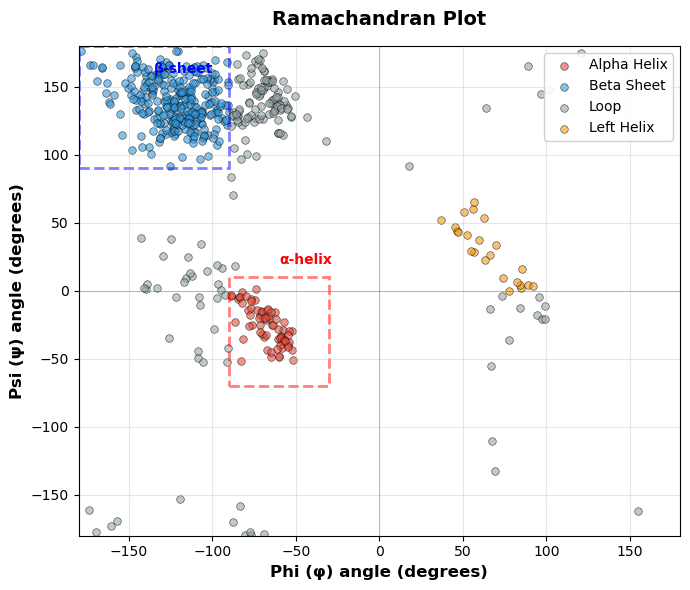

In [17]:
# Ramachandran plot
df_rama = df.dropna(subset=['phi', 'psi'])

if len(df_rama) > 0:
    fig, ax = plt.subplots(figsize=(7, 6))
    
    # Color by secondary structure if available
    if 'secondary_structure' in df_rama.columns:
        ss_colors = {
            'alpha_helix': '#e74c3c',
            'beta_sheet': '#3498db',
            'loop': '#95a5a6',
            'left_helix': '#f39c12'
        }
        
        for ss, color in ss_colors.items():
            subset = df_rama[df_rama['secondary_structure'] == ss]
            if len(subset) > 0:
                ax.scatter(subset['phi'], subset['psi'], 
                          c=color, label=ss.replace('_', ' ').title(),
                          alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
    else:
        ax.scatter(df_rama['phi'], df_rama['psi'], 
                  c='#667eea', alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
    
    # Draw typical regions
    # Alpha helix region
    ax.add_patch(plt.Rectangle((-90, -70), 60, 80, 
                               fill=False, edgecolor='red', linewidth=2, 
                               linestyle='--', alpha=0.5))
    ax.text(-60, 20, 'α-helix', fontsize=10, color='red', fontweight='bold')
    
    # Beta sheet region  
    ax.add_patch(plt.Rectangle((-180, 90), 90, 90,
                               fill=False, edgecolor='blue', linewidth=2,
                               linestyle='--', alpha=0.5))
    ax.text(-135, 160, 'β-sheet', fontsize=10, color='blue', fontweight='bold')
    
    ax.set_xlabel('Phi (φ) angle (degrees)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Psi (ψ) angle (degrees)', fontsize=12, fontweight='bold')
    ax.set_title('Ramachandran Plot', fontsize=14, fontweight='bold', pad=15)
    ax.set_xlim(-180, 180)
    ax.set_ylim(-180, 180)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.axvline(x=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
    
    if 'secondary_structure' in df_rama.columns:
        ax.legend(loc='upper right', framealpha=0.9)
    
    plt.tight_layout()
    plt.show()
else:
    print("No phi/psi angles available for plotting")

### 9.4 VdW Energy Distribution (if available)

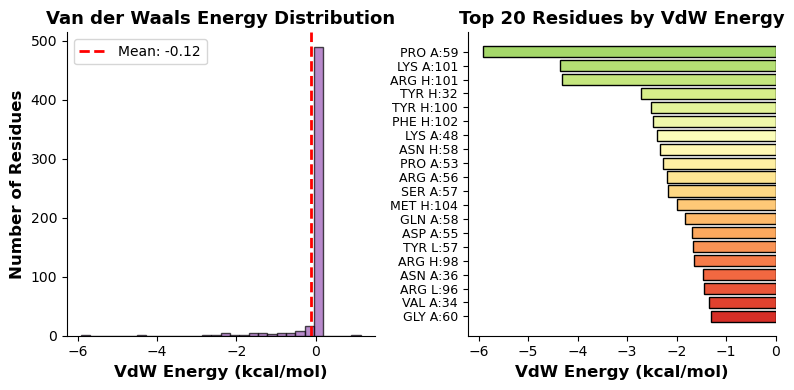


VdW Energy Statistics:
  Mean:   -0.12 kcal/mol
  Median: 0.00 kcal/mol
  Min:    -5.92 kcal/mol
  Max:    1.13 kcal/mol


In [18]:
# VdW energy analysis
df_vdw = df.dropna(subset=['vdw_energy'])

if len(df_vdw) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    
    # Histogram
    ax1.hist(df_vdw['vdw_energy'], bins=30, color='#9b59b6', 
             edgecolor='black', alpha=0.7)
    ax1.set_xlabel('VdW Energy (kcal/mol)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Number of Residues', fontsize=12, fontweight='bold')
    ax1.set_title('Van der Waals Energy Distribution', fontsize=13, fontweight='bold')
    ax1.axvline(df_vdw['vdw_energy'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f'Mean: {df_vdw["vdw_energy"].mean():.2f}')
    ax1.legend()
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # Top 20 residues by VdW energy
    top_vdw = df_vdw.nsmallest(20, 'vdw_energy')[['residue_id', 'vdw_energy']].sort_values('vdw_energy')
    
    colors_gradient = plt.cm.RdYlGn_r(np.linspace(0.3, 0.9, len(top_vdw)))
    bars = ax2.barh(range(len(top_vdw)), top_vdw['vdw_energy'], 
                    color=colors_gradient, edgecolor='black', linewidth=1)
    ax2.set_yticks(range(len(top_vdw)))
    ax2.set_yticklabels(top_vdw['residue_id'], fontsize=9)
    ax2.set_xlabel('VdW Energy (kcal/mol)', fontsize=12, fontweight='bold')
    ax2.set_title('Top 20 Residues by VdW Energy', fontsize=13, fontweight='bold')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nVdW Energy Statistics:")
    print(f"  Mean:   {df_vdw['vdw_energy'].mean():.2f} kcal/mol")
    print(f"  Median: {df_vdw['vdw_energy'].median():.2f} kcal/mol")
    print(f"  Min:    {df_vdw['vdw_energy'].min():.2f} kcal/mol")
    print(f"  Max:    {df_vdw['vdw_energy'].max():.2f} kcal/mol")
else:
    print("No VdW energy data available")

## 10. Export Features

Export features to various formats for further analysis or machine learning.

### 10.1 Export to CSV

In [ ]:
# Export all features to CSV
export_features_csv(
    features,
    output_path="residue_features_all.csv",
    include_empty_columns=False  # Omit columns with all empty values
)

print("✓ Exported all features to: residue_features_all.csv")

In [ ]:
# Export only interface residues
export_features_csv(
    interface_features,
    output_path="residue_features_interface.csv",
    include_empty_columns=False
)

print("✓ Exported interface features to: residue_features_interface.csv")

In [ ]:
# Export hotspots
export_features_csv(
    hotspots,
    output_path="residue_features_hotspots.csv",
    include_empty_columns=False
)

print("✓ Exported hotspot features to: residue_features_hotspots.csv")

### 10.2 Export to JSON

In [ ]:
# Export to JSON format (useful for web apps or APIs)
export_features_json(
    features,
    output_path="residue_features.json",
    pretty=True  # Pretty-print with indentation
)

print("✓ Exported features to: residue_features.json")

## 11. Create Interactive HTML Dashboard

Generate an interactive web-based dashboard for exploring the features.

In [ ]:
# Create interactive dashboard
create_interactive_dashboard(
    features,
    output_path="residue_features_dashboard.html",
    title="5GGS Antibody-Antigen Residue Features",
    include_3d=True
)

## 12. Advanced Analysis Examples

### 12.1 Correlation Analysis

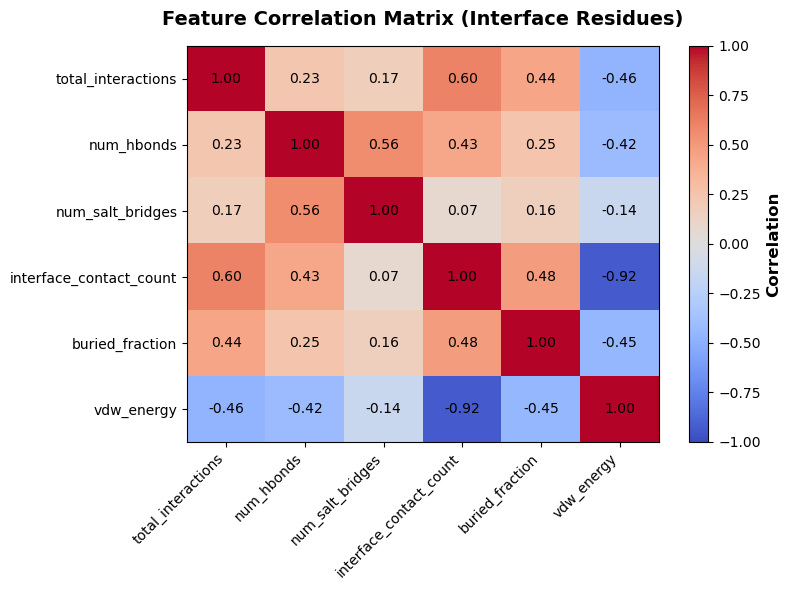

In [21]:
# Analyze correlations between features (for interface residues)
df_interface_numeric = df_interface.select_dtypes(include=[np.number])

# Calculate correlation matrix
features_of_interest = [
    'total_interactions', 'num_hbonds', 'num_salt_bridges',
    'interface_contact_count', 'buried_fraction', 'vdw_energy'
]

# Filter to available columns
available_features = [f for f in features_of_interest if f in df_interface_numeric.columns]

if len(available_features) > 1:
    corr_matrix = df_interface_numeric[available_features].corr()
    
    # Plot correlation heatmap
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    
    # Set ticks
    ax.set_xticks(np.arange(len(available_features)))
    ax.set_yticks(np.arange(len(available_features)))
    ax.set_xticklabels(available_features, rotation=45, ha='right')
    ax.set_yticklabels(available_features)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Correlation', fontsize=12, fontweight='bold')
    
    # Add correlation values
    for i in range(len(available_features)):
        for j in range(len(available_features)):
            text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=10)
    
    ax.set_title('Feature Correlation Matrix (Interface Residues)', 
                fontsize=14, fontweight='bold', pad=15)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric features for correlation analysis")

### 12.2 Feature Importance for Hotspot Prediction

In [22]:
# Analyze which features distinguish hotspots from regular interface residues
df_interface['is_hotspot'] = df_interface['residue_id'].isin(df_hotspots['residue_id'])

print("=" * 80)
print("HOTSPOT vs NON-HOTSPOT INTERFACE RESIDUES COMPARISON".center(80))
print("=" * 80)

comparison_features = [
    'total_interactions', 'num_hbonds', 'num_salt_bridges',
    'num_hydrophobic', 'interface_contact_count'
]

print(f"\n{'Feature':<30}{'Hotspot Mean':<20}{'Non-Hotspot Mean':<20}{'Ratio':<10}")
print("-" * 80)

for feat in comparison_features:
    if feat in df_interface.columns:
        hotspot_mean = df_interface[df_interface['is_hotspot']][feat].mean()
        non_hotspot_mean = df_interface[~df_interface['is_hotspot']][feat].mean()
        ratio = hotspot_mean / non_hotspot_mean if non_hotspot_mean > 0 else 0
        print(f"{feat:<30}{hotspot_mean:<20.2f}{non_hotspot_mean:<20.2f}{ratio:<10.2f}x")

print("=" * 80)

              HOTSPOT vs NON-HOTSPOT INTERFACE RESIDUES COMPARISON              

Feature                       Hotspot Mean        Non-Hotspot Mean    Ratio     
--------------------------------------------------------------------------------
total_interactions            6.82                2.15                3.18      x
num_hbonds                    2.18                0.29                7.48      x
num_salt_bridges              0.82                0.02                39.27     x
num_hydrophobic               3.82                1.83                2.08      x
interface_contact_count       42.73               17.83               2.40      x


## 13. Summary

This notebook demonstrated how to:

1. Extract comprehensive residue features from protein complexes
2. Convert features to pandas DataFrame for analysis
3. Generate summary statistics
4. Filter interface residues and identify hotspots
5. Create visualizations for feature distributions
6. Export features to CSV and JSON formats
7. Generate interactive HTML dashboards
8. Perform correlation and comparative analyses

### Key Functions:

- `extract_residue_features()` - Main function to extract all features
- `features_to_dataframe()` - Convert to pandas DataFrame
- `filter_interface_residues()` - Filter to interface only
- `identify_hotspots()` - Find hotspot residues
- `get_feature_summary()` - Get summary statistics
- `export_features_csv()` - Export to CSV
- `export_features_json()` - Export to JSON
- `create_interactive_dashboard()` - Create HTML dashboard

### Applications:

- **Machine Learning**: Use feature matrix for ML models
- **Protein Engineering**: Identify mutation targets
- **Drug Design**: Find binding hotspots
- **Comparative Studies**: Compare features across structures
- **Quality Assessment**: Analyze structure quality metrics